In [98]:
import numpy as np
# import sympy as sp

class ilqr:
    def __init__(self,init_state,target_state,initial_guess,dt,start_time,end_time,f_disc,A,B,Q_k,R_k,Q_T,parameters,n_iterations,traj):
        self.init_state_ = init_state
        self.target_state_ = target_state
        self.inputs_ = initial_guess
        self.n_states_ = np.shape(init_state)[0]
        self.n_inputs_ = np.shape(initial_guess)[1]
        self.traj_state_= traj

        self.dt_ = dt
        self.start_time_ = start_time
        self.end_time_ = end_time
        self.time_span_ = np.arange(start_time, end_time, dt).flatten()
        self.n_timesteps_ = np.shape(self.time_span_)[0]
        # Dynamics
        self.f_ = f_disc
        self.A_ = A
        self.B_ = B
        # Weighting
        self.Q_k_ = Q_k
        self.R_k_ = R_k
        self.Q_T_ = Q_T
        self.parameters_ = parameters

        # Max iterations
        self.n_iterations_ = n_iterations

    def rollout(self):
        states = np.zeros((self.n_timesteps_ + 1, self.n_states_))
        inputs = np.zeros((self.n_timesteps_, self.n_inputs_))
        current_state = self.init_state_

        for ii in range(0,self.n_timesteps_):
            current_input = self.inputs_[ii,:]
            next_state = self.f_(current_state, current_input, self.dt_).flatten()
            #next_state = self.f_(current_state, current_input, self.dt_, self.parameters_).flatten()
            # Store states and inputs
            states[ii + 1,:] = next_state
            inputs[ii,:] = current_input # in case we have a control law, we store the input used
            # Update the current state
            current_state = next_state

        # Store the trajectory(states, inputs)
        self.states_ = states
        self.inputs_ = inputs
        return states, inputs

    def compute_cost(self,states,inputs):
        # Initialize cost
        total_cost = 0.0
        for ii in range(0,self.n_timesteps_):
            current_x = states[ii,:].flatten() 
            current_u = inputs[ii,:].flatten()
            traj_diff= (self.traj_state_[ii,:].flatten()-current_x)
            current_cost =  traj_diff.T@self.Q_T_@traj_diff
            current_cost += current_u.T@self.R_k_@current_u 
            total_cost = total_cost+current_cost
        # Compute terminal cost
        #terminal_difference = (self.target_state_-states[-1,:]).flatten()
        #terminal_cost = terminal_difference.T@self.Q_T_@terminal_difference
        #total_cost = total_cost+terminal_cost
        return total_cost

    def backwards_pass(self):
        # First compute initial conditions (end boundary condition)
        # Value function hessian and gradient
        V_xx = self.Q_T_
        end_difference = (self.states_[-1, :] - self.target_state_).flatten()
        end_difference = end_difference.flatten()  # Make sure its the right dimension
        V_x = self.Q_T_@end_difference

        # Initialize storage variables
        k_trj = np.zeros((self.n_timesteps_,self.n_inputs_))
        K_trj = np.zeros((self.n_timesteps_,self.n_inputs_,self.n_states_))

        # Initialize cost reduction
        expected_cost_reduction = 0
        expected_cost_reduction_grad = 0
        expected_cost_reduction_hess = 0

        # for loop backwards in time
        for idx in reversed(range(0, self.n_timesteps_)):
            # Grab the current variables in the trajectory
            current_x = self.states_[idx,:]
            current_u = self.inputs_[idx,:]

            # R_k_updated
            # Define the expansion coefficients and the loss gradients
            l_xx = self.Q_k_ # For now zeros, can add in a target to track later on
            l_uu = self.R_k_

            l_x = self.Q_k_@np.zeros(self.n_states_).flatten() # For now zeros, can add in a target to track later on
            l_u = self.R_k_@(current_u).flatten()

            # Get the jacobian of the discretized dynamics
            #A_k = self.A_(current_x, current_u, self.dt_, self.parameters_)
            #B_k = self.B_(current_x, current_u, self.dt_, self.parameters_)
            A_k = self.A_(current_x, current_u, self.dt_)
            B_k = self.B_(current_x, current_u, self.dt_)

            Q_x = l_x + A_k.T@V_x
            Q_u = l_u+B_k.T@V_x
            Q_ux = B_k.T@V_xx@A_k
            Q_uu = l_uu + B_k.T@V_xx@B_k
            Q_xx = l_xx+A_k.T@V_xx@A_k

            # Compute gains
            Q_uu_inv = np.linalg.inv(Q_uu) # This can sometimes go singular
            k = -Q_uu_inv@Q_u
            K = -Q_uu_inv@Q_ux

            # Store gains
            k_trj[idx,:] = k
            K_trj[idx,:,:] = K

            # Update the expected reduction
            current_cost_reduction_grad = -Q_u.T@k
            current_cost_reduction_hess = 0.5 * k.T @ (Q_uu) @ (k)
            current_cost_reduction = current_cost_reduction_grad + current_cost_reduction_hess

            expected_cost_reduction_grad +=  current_cost_reduction_grad
            expected_cost_reduction_hess +=  current_cost_reduction_hess
            expected_cost_reduction += + current_cost_reduction

            # Update hessian and gradient for value function (If we arent using regularization we can simplify this computation)
            V_x = Q_x +K.T@Q_uu@k +K.T@Q_u + Q_ux.T@k
            V_xx = (Q_xx+Q_ux.T@K+K.T@Q_ux+K.T@Q_uu@K)

        # Store expected cost reductions
        self.expected_cost_reduction_grad_ = expected_cost_reduction_grad
        self.expected_cost_reduction_hess_ = expected_cost_reduction_hess
        self.expected_cost_reduction_ = expected_cost_reduction

        # Store gain schedule
        self.k_feedforward_ = k_trj
        self.K_feedback_ = K_trj
        return (k_trj,K_trj,expected_cost_reduction)

    def forwards_pass(self, learning_rate):
        states = np.zeros((self.n_timesteps_ + 1, self.n_states_))
        inputs = np.zeros((self.n_timesteps_, self.n_inputs_))
        current_state = self.init_state_

        # set the first state to be  the initial
        states[1,:] = current_state
        for ii in range(0,self.n_timesteps_):
            # Get the current gains and compute the feedforward and feedback terms
            current_feedforward = learning_rate * self.k_feedforward_[ii,:]
            current_feedback = self.K_feedback_[ii,:,:]@(current_state - self.states_[ii,:])
            current_input = self.inputs_[ii,:] + current_feedback + current_feedforward

            # simulate forward
            #next_state = self.f_(current_state, current_input, self.dt_, self.parameters_).flatten()
            next_state = self.f_(current_state, current_input, self.dt_).flatten()
            # Store states and inputs
            states[ii + 1,:] = next_state
            inputs[ii,:] = current_input.flatten()

            # Update the current state
            current_state = next_state
        return (states,inputs)
    def solve(self):
        # Compute the rollout to get the initial trajectory with the
        # initial guess
        [states,inputs] = self.rollout()
        # Compute the current cost of the initial trajectory
        current_cost = self.compute_cost(states,inputs)
        
        learning_speed = 0.95 # This can be modified, 0.95 is very slow
        low_learning_rate = 0.05 # if learning rate drops to this value stop the optimization
        low_expected_reduction = 1e-9 # Determines optimality
        armijo_threshold = 0.1 # Determines if current line search solve is good (this is typically labeled as "c")
        for ii in range(0,self.n_iterations_):
            print('Starting iteration: ',ii,', Current cost: ',current_cost)
            # Compute the backwards pass
            (k_feedforward,K_feedback,expected_reduction) = self.backwards_pass()
            print('Expected cost reduction: ',expected_reduction)
            if(abs(expected_reduction)<low_expected_reduction):
                # If the expected reduction is low, then end the
                # optimization
                print("Stopping optimization, optimal trajectory")
                break
            learning_rate = 1
            armijo_flag = 0
            # Execute linesearch until the armijo condition is met (for
            # now just check if the cost decreased) TODO add real
            # armijo condition
            while(learning_rate > 0.05 and armijo_flag == 0):
                # Compute forward pass
                (new_states,new_inputs)=self.forwards_pass(learning_rate)
                new_cost = self.compute_cost(new_states,new_inputs)

                # Calculate armijo condition
                cost_difference = (current_cost - new_cost)
                expected_cost_redu = learning_rate*self.expected_cost_reduction_grad_ + learning_rate*learning_rate*self.expected_cost_reduction_hess_
                armijo_flag = cost_difference/expected_cost_redu > armijo_threshold
                if(armijo_flag == 1):
                    # Accept the new trajectory if armijo condition is
                    # met
                    current_cost = new_cost
                    self.states_ = new_states
                    self.inputs_ = new_inputs
                else:
                    # If no improvement, decrease the learning rate
                    learning_rate = learning_speed*learning_rate
                    # print('Reducing learning rate to: ',learning_rate)
            if(learning_rate<low_learning_rate):
                # If learning rate is low, then stop optimization
                print("Stopping optimization, low learning rate")
                break
        # Return the current trajectory
        states = self.states_
        inputs = self.inputs_
        return states,inputs,k_feedforward,K_feedback,current_cost



        

In [99]:
import numpy as np
import sympy as sp
from sympy.matrices import Matrix

def symbolic_food_system(A_d,B_d):
        # Define the states and inputs
    x_1,x_2,x_3,x_4,u,dt = sp.symbols('x_1 x_2 x_3 x_4 u dt')
    inputs = Matrix([u])
    states = Matrix([x_1,x_2,x_3,x_4])
    # Defining the dynamics of the system
    x = [x_1,x_2,x_3,x_4]
    u = [u]
    x_vec = sp.Matrix(x)
    u_vec = sp.Matrix(u)

    # Define the system dynamics
    A_d1=Matrix([[A_d[0,0],A_d[0,1],A_d[0,2],A_d[0,3]],[A_d[1,0],A_d[1,1],A_d[1,2],A_d[1,3]],[A_d[2,0],A_d[2,1],A_d[2,2],A_d[2,3]],[A_d[3,0],A_d[3,1],A_d[3,2],A_d[3,3]]])
    B_d1=Matrix([[B_d[0]],[B_d[1]],[B_d[2]],[B_d[3]]])
    f = A_d1 @ x_vec + B_d1 @ u_vec

    # Discretize the dynamics using Euler integration
    f_disc = x_vec + dt * f

    # Compute the Jacobians with respect to states and inputs
    A_disc = f_disc.jacobian(x_vec)
    B_disc = f_disc.jacobian(u_vec)

    # Convert the symbolic expressions to callable functions
    f_disc_func = sp.lambdify((x_vec, u_vec, dt), f_disc)
    A_disc_func = sp.lambdify((x_vec, u_vec, dt), A_disc)
    B_disc_func = sp.lambdify((x_vec, u_vec, dt), B_disc)

    return f_disc_func, A_disc_func, B_disc_func





In [116]:
import torch
A=torch.load('/Users/avi/Desktop/Food_GVAE-master/E2C_spring_mass/latent_2/control_data_2.pt')
A=A[:100]
states=[]
A_mat=[]
B_mat=[]
for i in range(len(A)):
    states.append(A[i][0].detach().numpy()[:4])
    A_mat.append(A[i][1].detach().numpy()[:4,:4])
    B_mat.append(A[i][2].detach().numpy()[:4,:1].squeeze())
A_d=A_mat[1]
B_d=B_mat[1]


R = np.array([[0.001]])

In [117]:
states_og = np.array(states)

In [118]:
states_og[:,0] 


array([-0.1552724 ,  0.0454363 , -0.08574445, -0.4746391 , -0.12835871,
       -0.70218017, -0.18756224, -0.34922104, -0.26879053,  0.08246097,
        0.01102862,  0.12267659,  0.05101237,  0.21300307,  0.34883961,
        0.36428786,  0.34166747,  0.34395471,  0.37847647,  0.34063877,
        0.44593972,  0.41897001,  0.34770583,  0.03055981,  0.21274335,
        0.3643086 , -0.0420734 ,  0.07344078,  0.21624689,  0.02379807,
        0.07364288,  0.09188224, -0.0929635 ,  0.18819791,  0.08354989,
        0.0130505 , -0.01043636, -0.23278245, -0.16645077, -0.19671763,
       -0.13071937,  0.15944889,  0.08245953,  0.13804684,  0.20514538,
        0.16239367,  0.10905897,  0.01456295,  0.15787157,  0.12067416,
        0.25501377,  0.24055218, -0.08219936,  0.26114863, -0.2609601 ,
       -0.00966981,  0.17319489,  0.18289217,  0.17171849, -0.33254072,
       -0.023435  , -0.18050138, -0.37713934, -0.33883104, -0.24429192,
       -0.38315289, -0.20918665, -0.34670735, -0.36892733, -0.26

In [122]:
import numpy as np


# Import dynamics
(f,A,B) = symbolic_food_system(A_d,B_d)

# Initialize timings
dt = 0.1
start_time = 0
end_time = 10
time_span = np.arange(start_time, end_time, dt).flatten()

# Set desired state
n_states = 4
n_inputs = 1
init_state = np.array([0,0,0,0])   # Initial state
target_state = states[-1]  # Target state

# Initial guess of zeros, but you can change it to any guess
initial_guess = 0.1*np.ones((np.shape(time_span)[0],n_inputs))
# Define weighting matrices
Q_k = np.zeros((n_states,n_states)) # zero weight to penalties along a strajectory since we are finding a trajectory
R_k = 0.1*np.eye(n_inputs)

# Set the terminal cost
Q_T = 10*np.eye(n_states)

parameters =np.array([0.1,0.1,0.1,0.1])
# Specify max number of iterations
n_iterations = 100

# Initialize ilqr object
ilqr_ = ilqr(init_state,target_state,initial_guess,dt,start_time,end_time,f,A,B,Q_k,R_k,Q_T,parameters,n_iterations,states_og)

# Solve for swing up
(states,inputs,k_feedforward,K_feedback,current_cost) = ilqr_.solve()

# 




Starting iteration:  0 , Current cost:  188888.78255701478
Expected cost reduction:  60775.5764504792
Starting iteration:  1 , Current cost:  291.38920667827324
Expected cost reduction:  1.5770956001762342e-23
Stopping optimization, optimal trajectory


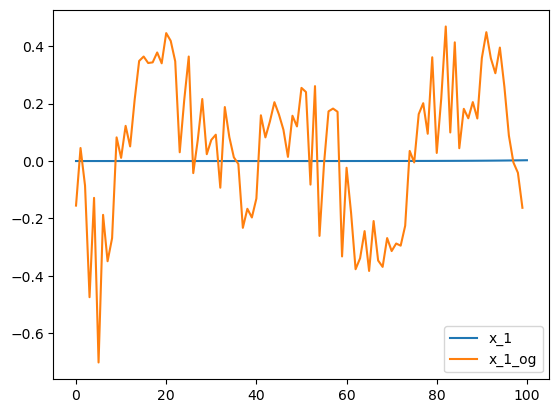

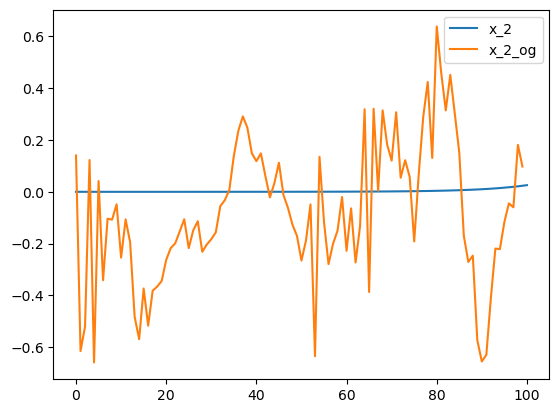

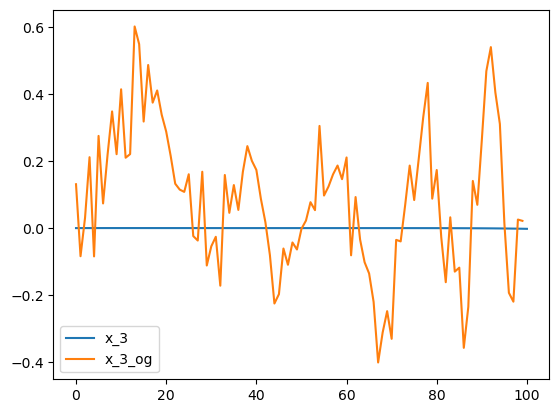

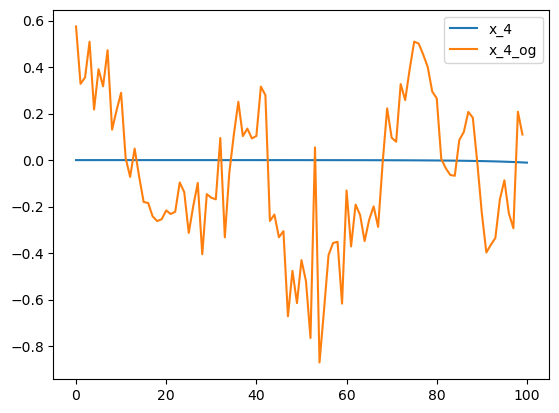

In [123]:
# Plot the results by comparing the states and states_og in each dimension
import matplotlib.pyplot as plt
plt.figure()
plt.plot(states[:,0],label='x_1')
plt.plot(states_og[:,0],label='x_1_og')
plt.legend()
plt.figure()
plt.plot(states[:,1],label='x_2')
plt.plot(states_og[:,1],label='x_2_og')
plt.legend()
plt.figure()
plt.plot(states[:,2],label='x_3')
plt.plot(states_og[:,2],label='x_3_og')
plt.legend()
plt.figure()
plt.plot(states[:,3],label='x_4')
plt.plot(states_og[:,3],label='x_4_og')
plt.legend()
plt.show()